<a href="https://colab.research.google.com/github/Norwicklee/Workspace/blob/main/SSFS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install torch torchvision albumentations segmentation-models-pytorch ternausnet
!apt-get install -qq nvidia-smi


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 106.7/106.7 kB 3.7 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [2]:
import os
import numpy as np
import torch
import albumentations as A
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.utils.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU
import cv2
from matplotlib import pyplot as plt
from albumentations.pytorch import ToTensorV2

In [3]:
import os
import shutil
from sklearn.model_selection import train_test_split

# Set the paths
dataset_dir = '/content/drive/My Drive/dataset/SlapScanDataset/'
images_dir = os.path.join(dataset_dir, 'Training_Images/')
masks_dir = os.path.join(dataset_dir, 'Ground_Truth/')

train_images_dir = os.path.join(dataset_dir, 'Train_Images/')
val_images_dir = os.path.join(dataset_dir, 'Val_Images/')
test_images_dir = os.path.join(dataset_dir, 'Test_Images/')

train_masks_dir = os.path.join(dataset_dir, 'Train_Ground_Truth/')
val_masks_dir = os.path.join(dataset_dir, 'Val_Ground_Truth/')
test_masks_dir = os.path.join(dataset_dir, 'Test_Ground_Truth/')

# Create directories if they do not exist
os.makedirs(train_images_dir, exist_ok=True)
os.makedirs(val_images_dir, exist_ok=True)
os.makedirs(test_images_dir, exist_ok=True)

os.makedirs(train_masks_dir, exist_ok=True)
os.makedirs(val_masks_dir, exist_ok=True)
os.makedirs(test_masks_dir, exist_ok=True)

# Get the list of all images
image_files = sorted(os.listdir(images_dir))
mask_files = sorted(os.listdir(masks_dir))

# Split the dataset into training, validation, and test sets
train_images, val_test_images, train_masks, val_test_masks = train_test_split(
    image_files, mask_files, test_size=0.36, random_state=42)

val_images, test_images, val_masks, test_masks = train_test_split(
    val_test_images, val_test_masks, test_size=0.40, random_state=42)

# Function to copy files to the respective directories
def copy_files(file_list, source_dir, destination_dir):
    for file_name in file_list:
        shutil.copy(os.path.join(source_dir, file_name), destination_dir)

# Copy the files to the respective directories
copy_files(train_images, images_dir, train_images_dir)
copy_files(val_images, images_dir, val_images_dir)
copy_files(test_images, images_dir, test_images_dir)

copy_files(train_masks, masks_dir, train_masks_dir)
copy_files(val_masks, masks_dir, val_masks_dir)
copy_files(test_masks, masks_dir, test_masks_dir)


In [4]:
import os
from PIL import Image
import torch
from torch.utils.data import Dataset
import torchvision.transforms as transforms

class SlapScanDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        images_dir = os.path.join(self.images_dir, self.image_filenames[idx])
        masks_dir = os.path.join(self.masks_dir, self.mask_filenames[idx])

        image =np.array(Image.open(images_dir).convert('RGB'))
        mask = np.array(Image.open(masks_dir).convert('L'))
        if image.shape[2] != mask.shape[:2]:
            image = cv2.resize(image, mask.shape[:2][::-1])



        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = torch.from_numpy(image).float() / 255.0
            mask = torch.from_numpy(mask).long()


        return image, mask

# Transformation (example)
import albumentations as A
from albumentations.pytorch import ToTensorV2

transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
], is_check_shapes=False)

# Dataset and DataLoader
# Dataset and DataLoader
train_dataset = SlapScanDataset(
    images_dir='/content/drive/My Drive/dataset/SlapScanDataset/Training_Images/', # Fixed typo here
    masks_dir='/content/drive/My Drive/dataset/SlapScanDataset/Ground_Truth/',
    transform=transform
)

val_dataset = SlapScanDataset(
    images_dir='/content/drive/My Drive/dataset/SlapScanDataset/Val_Images/',
    masks_dir='/content/drive/My Drive/dataset/SlapScanDataset/Val_Ground_Truth/',
    transform=transform
)

train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)

/usr/local/lib/python3.10/dist-packages/torch/utils/data/dataloader.py:558: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(_create_warning_msg(


In [5]:
transform = A.Compose([
    A.PadIfNeeded(min_height=256, min_width=256, value=0, mask_value=0, border_mode=cv2.BORDER_CONSTANT),
    A.HorizontalFlip(p=0.5),  # Flip horizontally with a 50% probability
    A.VerticalFlip(p=0.5),    # Flip vertically with a 50% probability
    A.RandomRotate90(p=0.5),  # Rotate by 90 degrees with a 50% probability
    A.ShiftScaleRotate(scale_limit=0.1, rotate_limit=30, shift_limit=0.1, p=0.5),  # Random shift, scale, and rotate
    A.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.2, p=0.5),   # Random color jitter
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),  # Normalize the image
    ToTensorV2()  # Convert image and mask to PyTorch tensors
])


val_transform = A.Compose([
    A.Resize(256, 256),
    A.PadIfNeeded(min_height=256, min_width=256, border_mode=cv2.BORDER_CONSTANT, value=0, mask_value=0, p=1.0),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2(),
])

train_images_path = '/content/drive/My Drive/dataset/SlapScanDataset/Training_Images/'
train_masks_path = '/content/drive/My Drive/dataset/SlapScanDataset/Ground_Truth/'

val_images_path = '/content/drive/My Drive/dataset/SlapScanDataset/Val_Images/'
val_masks_path = '/content/drive/My Drive/dataset/SlapScanDataset/Val_Ground_Truth/'

test_images_path = '/content/drive/My Drive/dataset/SlapScanDataset/Test_Images/'
test_masks_path = '/content/drive/My Drive/dataset/SlapScanDataset/Test_Ground_Truth/'

train_dataset = SlapScanDataset(train_images_path, train_masks_path, transform=transform)
val_dataset = SlapScanDataset(val_images_path, val_masks_path, transform=transform)
test_dataset = SlapScanDataset(test_images_path, test_masks_path, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=16, shuffle=False, num_workers=2)


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [7]:
model = Unet(
    encoder_name="resnet34",  # choose encoder, e.g. mobilenet_v2 or efficientnet-b7
    encoder_weights="imagenet",  # use `imagenet` pre-trained weights for encoder initialization
    in_channels=3,  # model input channels (1 for grayscale images, 3 for RGB, etc.)
    classes=1,  # model output channels (number of classes in your dataset)
).to(device)


Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:00<00:00, 204MB/s]


In [8]:
loss_fn = DiceLoss()
metrics = [IoU(threshold=0.5)]
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)


In [9]:
import torch
import torch.nn.functional as F

def compute_iou(preds, labels, threshold=0.5):
    preds = (F.sigmoid(preds) > threshold).float()
    intersection = (preds & labels).float().sum((1, 2, 3))
    union = (preds | labels).float().sum((1, 2, 3))
    iou = (intersection + 1e-6) / (union + 1e-6)
    return iou.mean()


In [10]:
# Create the validation dataset
val_dataset = SlapScanDataset(
    images_dir='/content/drive/My Drive/dataset/SlapScanDataset/Val_Images/',
    masks_dir='/content/drive/My Drive/dataset/SlapScanDataset/Val_Ground_Truth/',
    transform=transform
)

# Validation DataLoader
val_loader = DataLoader(val_dataset, batch_size=16, shuffle=False, num_workers=4)


In [11]:
import torch.optim as optim
import torch.nn as nn

loss_fn = nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=0.003)
metrics = [compute_iou]


In [12]:
import os
import numpy as np
import torch
import albumentations as A
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from segmentation_models_pytorch import Unet
from segmentation_models_pytorch.utils.losses import DiceLoss
from segmentation_models_pytorch.utils.metrics import IoU
import cv2
from matplotlib import pyplot as plt
from albumentations.pytorch import ToTensorV2

# Define Dataset Class
class SlapScanDataset(Dataset):
    def __init__(self, images_dir, masks_dir, transform=None):
        self.images_dir = images_dir
        self.masks_dir = masks_dir
        self.transform = transform
        self.image_filenames = sorted(os.listdir(images_dir))
        self.mask_filenames = sorted(os.listdir(masks_dir))

    def __len__(self):
        return len(self.image_filenames)

    def __getitem__(self, idx):
        image_path = os.path.join(self.images_dir, self.image_filenames[idx])
        mask_path = os.path.join(self.masks_dir, self.mask_filenames[idx])

        image = cv2.imread(image_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE)

        if self.transform:
            augmented = self.transform(image=image, mask=mask)
            image = augmented['image']
            mask = augmented['mask']
        else:
            image = transforms.ToTensor()(image)
            mask = transforms.ToTensor()(mask)

        return image, mask

# Define transformations
transform = A.Compose([
    A.Resize(512, 512),
    A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ToTensorV2()
], is_check_shapes=False)

# Load datasets
train_dataset = SlapScanDataset(
    images_dir='/content/drive/My Drive/dataset/SlapScanDataset/Training_Images/',
    masks_dir='/content/drive/My Drive/dataset/SlapScanDataset/Ground_Truth/',
    transform=transform
)

val_dataset = SlapScanDataset(
    images_dir='/content/drive/My Drive/dataset/SlapScanDataset/Val_Images/',
    masks_dir='/content/drive/My Drive/dataset/SlapScanDataset/Val_Ground_Truth/',
    transform=transform
)

# Data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False, num_workers=0, pin_memory=True)

# Model, loss, optimizer, metrics
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1).to(device)
loss_fn = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
metrics = [IoU()]

# Training function
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Initialize Learning Rate Scheduler
scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=2, verbose=True)

def train_model(model, train_loader, val_loader, loss_fn, metrics, optimizer, scheduler, device, num_epochs=10):
    best_iou = 0.0
    iou_metric = metrics[0]
    early_stopping_counter = 0
    best_model_path = 'best_model.pth'

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0.0
        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = loss_fn(outputs, masks.unsqueeze(1).float())
            loss.backward()
            optimizer.step()

            train_loss += loss.item()

        val_loss = 0.0
        val_iou_scores = []
        model.eval()
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)

                outputs = model(images)
                loss = loss_fn(outputs, masks.unsqueeze(1).float())

                val_loss += loss.item()
                val_iou_scores.append(iou_metric(outputs, masks.unsqueeze(1).float()).item())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        val_iou = sum(val_iou_scores) / len(val_iou_scores)

        print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val IoU: {val_iou:.4f}')

        # Update learning rate scheduler
        scheduler.step(val_iou)

        # Early stopping based on validation IoU
        if val_iou > best_iou:
            best_iou = val_iou
            torch.save(model.state_dict(), best_model_path)
            early_stopping_counter = 0
        else:
            early_stopping_counter += 1
            if early_stopping_counter >= 5:  # Adjust patience as needed
                print(f'Early stopping at epoch {epoch+1} with best IoU: {best_iou:.4f}')
                break

    print(f'Best validation IoU: {best_iou:.4f}')

# Train the model with scheduler and early stopping
train_model(model, train_loader, val_loader, loss_fn, metrics, optimizer, scheduler, device=device, num_epochs=10)


/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:28: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn("The verbose parameter is deprecated. Please use get_last_lr() "
/usr/local/lib/python3.10/dist-packages/torch/autograd/graph.py:744: UserWarning: Plan failed with a cudnnException: CUDNN_BACKEND_EXECUTION_PLAN_DESCRIPTOR: cudnnFinalize Descriptor Failed cudnn_status: CUDNN_STATUS_NOT_SUPPORTED (Triggered internally at ../aten/src/ATen/native/cudnn/Conv_v8.cpp:919.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 1/10, Train Loss: -5.1027, Val Loss: -217.5369, Val IoU: 47.1939
Epoch 2/10, Train Loss: -17.0947, Val Loss: -224.2585, Val IoU: 6.5152
Epoch 3/10, Train Loss: -29.2902, Val Loss: -45.8141, Val IoU: 1.2934
Epoch 4/10, Train Loss: -45.1909, Val Loss: -89.1935, Val IoU: 17.6161
Epoch 5/10, Train Loss: -64.4933, Val Loss: -92.9504, Val IoU: 22.5737
Epoch 6/10, Train Loss: -76.2395, Val Loss: -74.0340, Val IoU: 4.0221
Early stopping at epoch 6 with best IoU: 47.1939
Best validation IoU: 47.1939


In [13]:
from sklearn.metrics import jaccard_score

def compute_iou(y_true, y_pred):
    intersection = np.logical_and(y_true, y_pred)
    union = np.logical_or(y_true, y_pred)
    iou_score = np.sum(intersection) / np.sum(union)
    return iou_score


In [14]:
def compute_dice_coefficient(y_true, y_pred):
    intersection = np.sum(y_true * y_pred)
    dice_coefficient = (2. * intersection) / (np.sum(y_true) + np.sum(y_pred))
    return dice_coefficient


In [15]:
def visualize_predictions(images, masks, predictions):
    fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))

    for i, ax in enumerate(axes.flat):
        ax.imshow(images[i].permute(1, 2, 0))  # Assuming images are in torch.Tensor format
        ax.set_title(f'Predicted Mask')
        ax.axis('off')
        ax.imshow(predictions[i], alpha=0.5)

    plt.tight_layout()
    plt.show()


In [16]:
from sklearn.model_selection import KFold

# Define your model, optimizer, loss function, and other parameters
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1).to(device)
loss_fn = DiceLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
metrics = [IoU()]

# Define learning rate scheduler # NEW
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min') # Example scheduler, adjust as needed

# Define K-fold cross-validation
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

# Perform cross-validation
fold = 0
for train_index, val_index in kfold.split(train_dataset):
    fold += 1
    print(f"Fold {fold}")

    # Create data loaders for current fold
    train_sampler = torch.utils.data.SubsetRandomSampler(train_index)
    val_sampler = torch.utils.data.SubsetRandomSampler(val_index)

    train_loader = DataLoader(train_dataset, batch_size=8, sampler=train_sampler, num_workers=0, pin_memory=True)
    val_loader = DataLoader(train_dataset, batch_size=8, sampler=val_sampler, num_workers=0, pin_memory=True)

    # Initialize model, optimizer, etc. for each fold
    model = Unet(encoder_name="resnet34", encoder_weights="imagenet", in_channels=3, classes=1).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=0.003)
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min') # Initialize scheduler for each fold

    # Train the model
    train_model(model, train_loader, val_loader, loss_fn, metrics, optimizer, scheduler, device=device, num_epochs=10) # Pass the scheduler to the function

    # Evaluate on test set (if separate test set is available)
    # test_metrics = evaluate_model(model, test_loader, loss_fn, metrics, device=device)

    # Save or aggregate metrics for analysis

Fold 1
Epoch 1/10, Train Loss: -3.3003, Val Loss: -138.5406, Val IoU: 0.0000
Epoch 2/10, Train Loss: -13.7550, Val Loss: 43.7860, Val IoU: 0.0173
Epoch 3/10, Train Loss: -23.6899, Val Loss: -33.5774, Val IoU: 0.7431
Epoch 4/10, Train Loss: -36.2630, Val Loss: -14.4521, Val IoU: 0.4265
Epoch 5/10, Train Loss: -50.4645, Val Loss: -92.0612, Val IoU: 4.9401
Epoch 6/10, Train Loss: -64.5544, Val Loss: -101.7633, Val IoU: 10.6546
Epoch 7/10, Train Loss: -80.7036, Val Loss: -69.1269, Val IoU: 1.7174
Epoch 8/10, Train Loss: -98.2361, Val Loss: -118.5727, Val IoU: 4.1048
Epoch 9/10, Train Loss: -117.0255, Val Loss: -138.4212, Val IoU: 2.3023
Epoch 10/10, Train Loss: -134.7911, Val Loss: -195.2985, Val IoU: 6.1773
Best validation IoU: 10.6546
Fold 2
Epoch 1/10, Train Loss: -2.8261, Val Loss: -122.1052, Val IoU: 51.1197
Epoch 2/10, Train Loss: -14.6169, Val Loss: -191.0343, Val IoU: 57.0154
Epoch 3/10, Train Loss: -25.6821, Val Loss: -66.2390, Val IoU: 19.0929
Epoch 4/10, Train Loss: -39.2512, Va

{'IoU': 0.3333584075564221, 'Dice': 0.5000282079705052, 'Precision': 0.4992965938088075, 'Recall': 0.5007619693318797, 'Accuracy': 0.49965972900390626}


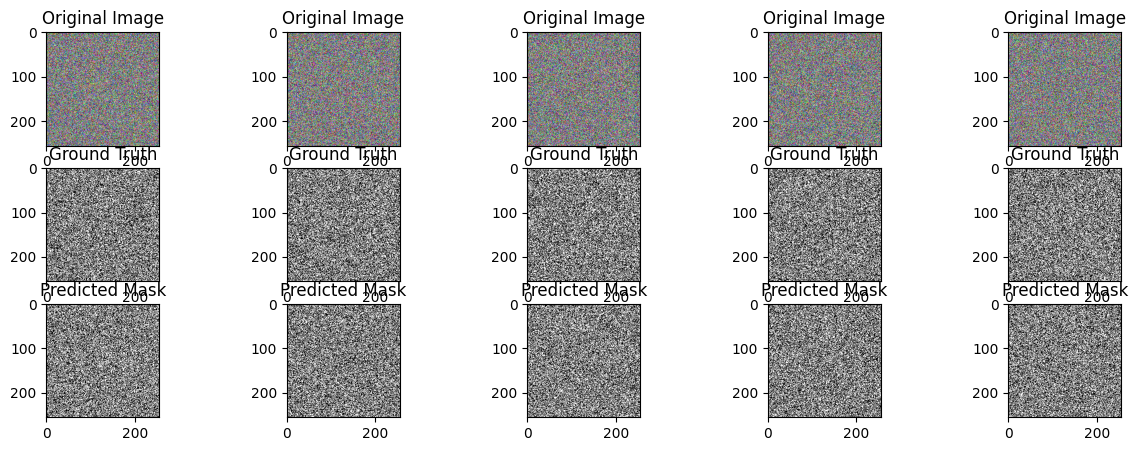

In [17]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import jaccard_score, f1_score, precision_score, recall_score, accuracy_score

def compute_metrics(y_true, y_pred):
    # Flatten the arrays
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Ensure binary format (if not already binary)
    y_true_flat = (y_true_flat > 0.5).astype(np.uint8)
    y_pred_flat = (y_pred_flat > 0.5).astype(np.uint8)

    # Calculate metrics
    iou = jaccard_score(y_true_flat, y_pred_flat, average='binary')
    dice = f1_score(y_true_flat, y_pred_flat, average='binary')
    precision = precision_score(y_true_flat, y_pred_flat, average='binary')
    recall = recall_score(y_true_flat, y_pred_flat, average='binary')
    accuracy = accuracy_score(y_true_flat, y_pred_flat)

    return {
        'IoU': iou,
        'Dice': dice,
        'Precision': precision,
        'Recall': recall,
        'Accuracy': accuracy
    }

def plot_segmentation_results(original_images, ground_truth_masks, predicted_masks, num_samples=5):
    plt.figure(figsize=(15, 5))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(original_images[i])
        plt.title('Original Image')

        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(ground_truth_masks[i], cmap='gray')
        plt.title('Ground Truth')

        plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
        plt.imshow(predicted_masks[i], cmap='gray')
        plt.title('Predicted Mask')

    plt.show()

# Assuming y_true and y_pred are the ground truth and predicted masks as numpy arrays
# Example placeholders (use your actual data)
y_true = np.random.randint(0, 2, (10, 256, 256))  # Example ground truth masks
y_pred = np.random.rand(10, 256, 256)  # Example predicted masks (probability maps)

# Ensure y_pred is thresholded to binary
y_pred_binary = (y_pred > 0.5).astype(np.uint8)

metrics = compute_metrics(y_true, y_pred_binary)
print(metrics)

# Example images for visualization (use your actual data)
original_images = np.random.rand(5, 256, 256, 3)
ground_truth_masks = y_true[:5]
predicted_masks = y_pred_binary[:5]

# Visualize some results
plot_segmentation_results(original_images, ground_truth_masks, predicted_masks)


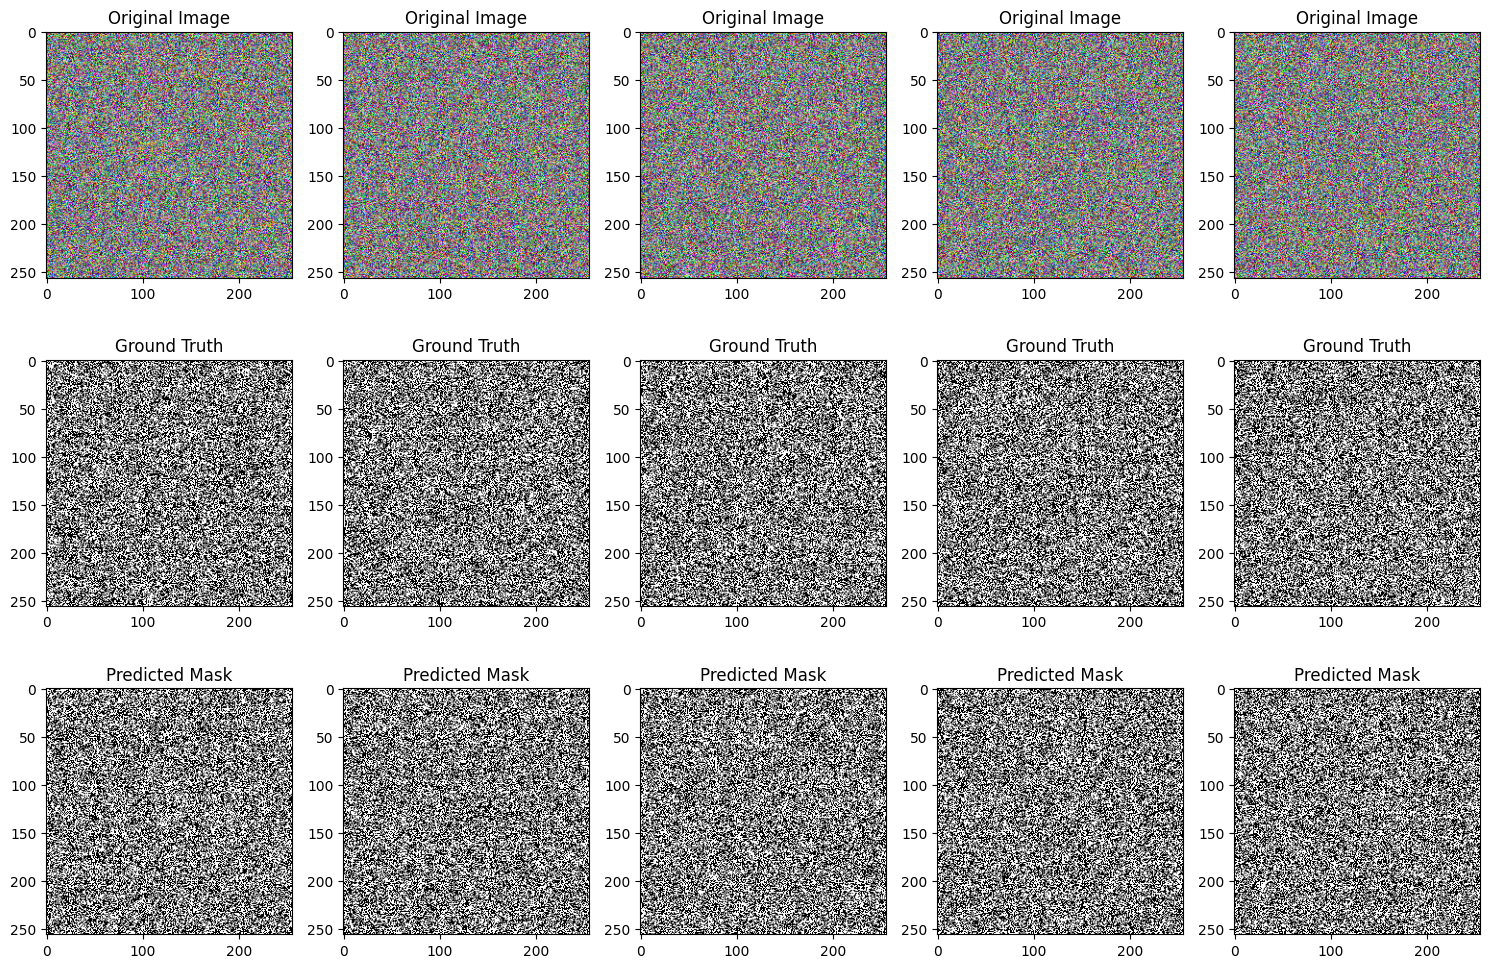

In [18]:
def plot_segmentation_results(original_images, ground_truth_masks, predicted_masks, num_samples=5):
    plt.figure(figsize=(15, 10))
    for i in range(num_samples):
        plt.subplot(3, num_samples, i + 1)
        plt.imshow(original_images[i])
        plt.title('Original Image')

        plt.subplot(3, num_samples, i + 1 + num_samples)
        plt.imshow(ground_truth_masks[i], cmap='gray')
        plt.title('Ground Truth')

        plt.subplot(3, num_samples, i + 1 + 2 * num_samples)
        plt.imshow(predicted_masks[i], cmap='gray')
        plt.title('Predicted Mask')

    plt.tight_layout()
    plt.show()

# Visualize some results
plot_segmentation_results(original_images, ground_truth_masks, predicted_masks)
